In [1]:
import numpy as np
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
import jax
from jax import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp

In [2]:
# setup for problem
# get the setup for the problem
from opentn.transformations import create_trotter_layers, create_kitaev_liouvillians
from opentn.optimization import frobenius_norm, compose_superops_list
d, N, gamma = 2, 4, 1
tau = 4
pbc = False 

Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=gamma, pbc=pbc)
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = create_trotter_layers(liouvillians=[Lvec, Lvec_odd, Lvec_even], tau=tau)
print(frobenius_norm(compose_superops_list([exp_Lvec_odd, exp_Lvec_even, exp_Lvec_odd]), exp_Lvec))

0.0959176702323516


In [3]:
from opentn.transformations import super2ortho
xs_nopbc_stiefel = [super2ortho(x.real, rank=4) for x in [exp_Lvec_odd, exp_Lvec_even, exp_Lvec_odd]]
print([op.shape for op in xs_nopbc_stiefel])

[(64, 16), (64, 16), (64, 16)]


In [28]:
from opentn.transformations import super2choi
np.linalg.matrix_rank(super2choi(exp_Lvec_odd)), np.linalg.svd(super2choi(exp_Lvec_odd), compute_uv=False)[:10]

(4,
 array([1.30070634e+01, 1.41905924e+00, 1.41905924e+00, 1.54818122e-01,
        5.31271329e-15, 4.26830863e-15, 4.06456094e-15, 3.83842620e-15,
        3.64950678e-15, 3.61578005e-15]))

In [29]:
[np.linalg.matrix_rank(super2choi(op)) for op in [exp_Lvec, exp_Lvec_odd, exp_Lvec_even]]

[55, 4, 2]

In [7]:
from opentn.optimization import model_Ys_stiefel
from opentn.stiefel import retract_stiefel, gradient_stiefel_vec, riemannian_hessian_vec
from opentn.trust_region_rcopt import riemannian_trust_region_optimize
f_stiefel = lambda xi: frobenius_norm(model_Ys_stiefel(xi), exp_Lvec)
grad_stiefel_euclidean = lambda xi: gradient_stiefel_vec(xi, f_stiefel, metric='euclidean')
hessian_stiefel_euclidean = lambda xi: riemannian_hessian_vec(xi, f_stiefel, metric='euclidean')
f_stiefel(xs_nopbc_stiefel)

DeviceArray(0.09591767, dtype=float64)

In [20]:
xs_nopbc_1, f_nopbc_1, err_nopbc_1, radius_nopbc_1 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel_euclidean, hessian_stiefel_euclidean, xs_nopbc_stiefel, niter=10
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.02
iteration: 1
column : 0
column : 1
column : 2
radius 0.02
iteration: 2
column : 0
column : 1
column : 2
radius 0.02
iteration: 3
column : 0
column : 1
column : 2
radius 0.02
iteration: 4
column : 0
column : 1
column : 2
radius 0.04
iteration: 5
column : 0
column : 1
column : 2
radius 0.04
iteration: 6
column : 0
column : 1
column : 2
radius 0.08
iteration: 7
column : 0
column : 1
column : 2
radius 0.08
iteration: 8
column : 0
column : 1
column : 2
radius 0.08
iteration: 9
column : 0
column : 1
column : 2
radius 0.02


In [23]:
xs_nopbc_2, f_nopbc_2, err_nopbc_2, radius_nopbc_2 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel_euclidean, hessian_stiefel_euclidean, xs_nopbc_1, niter=10, radius_init=radius_nopbc_1
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.04
iteration: 1
column : 0
column : 1
column : 2
radius 0.01
iteration: 2
column : 0
column : 1
column : 2
radius 0.02
iteration: 3
column : 0
column : 1
column : 2
radius 0.005
iteration: 4
column : 0
column : 1
column : 2
radius 0.01
iteration: 5
column : 0
column : 1
column : 2
radius 0.02
iteration: 6
column : 0
column : 1
column : 2
radius 0.005
iteration: 7
column : 0
column : 1
column : 2
radius 0.01
iteration: 8
column : 0
column : 1
column : 2
radius 0.01
iteration: 9
column : 0
column : 1
column : 2
radius 0.01


In [25]:
xs_nopbc_3, f_nopbc_3, err_nopbc_3, radius_nopbc_3 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel_euclidean, hessian_stiefel_euclidean, xs_nopbc_2, niter=10, radius_init=radius_nopbc_2
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.00125
iteration: 1
column : 0
column : 1
column : 2
radius 0.00125
iteration: 2
column : 0
column : 1
column : 2
radius 0.00125
iteration: 3
column : 0
column : 1
column : 2
radius 0.00125
iteration: 4
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 5
column : 0
column : 1
column : 2
radius 0.000625
iteration: 6
column : 0
column : 1
column : 2
radius 0.000625
iteration: 7
column : 0
column : 1
column : 2
radius 0.00125
iteration: 8
column : 0
column : 1
column : 2
radius 0.0025
iteration: 9
column : 0
column : 1
column : 2
radius 0.000625


In [8]:
grad_stiefel_canonical = lambda xi: gradient_stiefel_vec(xi, f_stiefel, metric='canonical')
hessian_stiefel_canonical = lambda xi: riemannian_hessian_vec(xi, f_stiefel, metric='canonical')

In [9]:
xs_nopbc_1_canonical, f_nopbc_1_canonical, err_nopbc_1_canonical, radius_nopbc_1_canonical = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel_canonical, hessian_stiefel_canonical, xs_nopbc_stiefel, niter=10
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.02
iteration: 1
column : 0
column : 1
column : 2
radius 0.02
iteration: 2
column : 0
column : 1
column : 2
radius 0.02
iteration: 3
column : 0
column : 1
column : 2
radius 0.04
iteration: 4
column : 0
column : 1
column : 2
radius 0.04
iteration: 5
column : 0
column : 1
column : 2
radius 0.04
iteration: 6
column : 0
column : 1
column : 2
radius 0.04
iteration: 7
column : 0
column : 1
column : 2
radius 0.04
iteration: 8
column : 0
column : 1
column : 2
radius 0.04
iteration: 9
column : 0
column : 1
column : 2
radius 0.01


In [11]:
xs_nopbc_2_canonical, f_nopbc_2_canonical, err_nopbc_2_canonical, radius_nopbc_2_canonical = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel_canonical, hessian_stiefel_canonical, xs_nopbc_1_canonical, niter=10, radius_init=radius_nopbc_1_canonical
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.01
iteration: 1
column : 0
column : 1
column : 2
radius 0.01
iteration: 2
column : 0
column : 1
column : 2
radius 0.01
iteration: 3
column : 0
column : 1
column : 2
radius 0.01
iteration: 4
column : 0
column : 1
column : 2
radius 0.01
iteration: 5
column : 0
column : 1
column : 2
radius 0.01
iteration: 6
column : 0
column : 1
column : 2
radius 0.0025
iteration: 7
column : 0
column : 1
column : 2
radius 0.0025
iteration: 8
column : 0
column : 1
column : 2
radius 0.0025
iteration: 9
column : 0
column : 1
column : 2
radius 0.0025


In [23]:
xs_nopbc_3_canonical, f_nopbc_3_canonical, err_nopbc_3_canonical, radius_nopbc_3_canonical = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel_canonical, hessian_stiefel_canonical, xs_nopbc_2_canonical, niter=10, radius_init=radius_nopbc_2_canonical
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.000625
iteration: 1
column : 0
column : 1
column : 2
radius 0.00125
iteration: 2
column : 0
column : 1
column : 2
radius 0.0025
iteration: 3
column : 0
column : 1
column : 2
radius 0.0025
iteration: 4
column : 0
column : 1
column : 2
radius 0.000625
iteration: 5
column : 0
column : 1
column : 2
radius 0.000625
iteration: 6
column : 0
column : 1
column : 2
radius 0.00125
iteration: 7
column : 0
column : 1
column : 2
radius 0.0025
iteration: 8
column : 0
column : 1
column : 2
radius 0.0025
iteration: 9
column : 0
column : 1
column : 2
radius 0.000625


In [15]:
from opentn.stiefel import check_isometries
check_isometries(xs_nopbc_2_canonical)#, check_isometries(xs_nopbc_3)

[True, True, True]

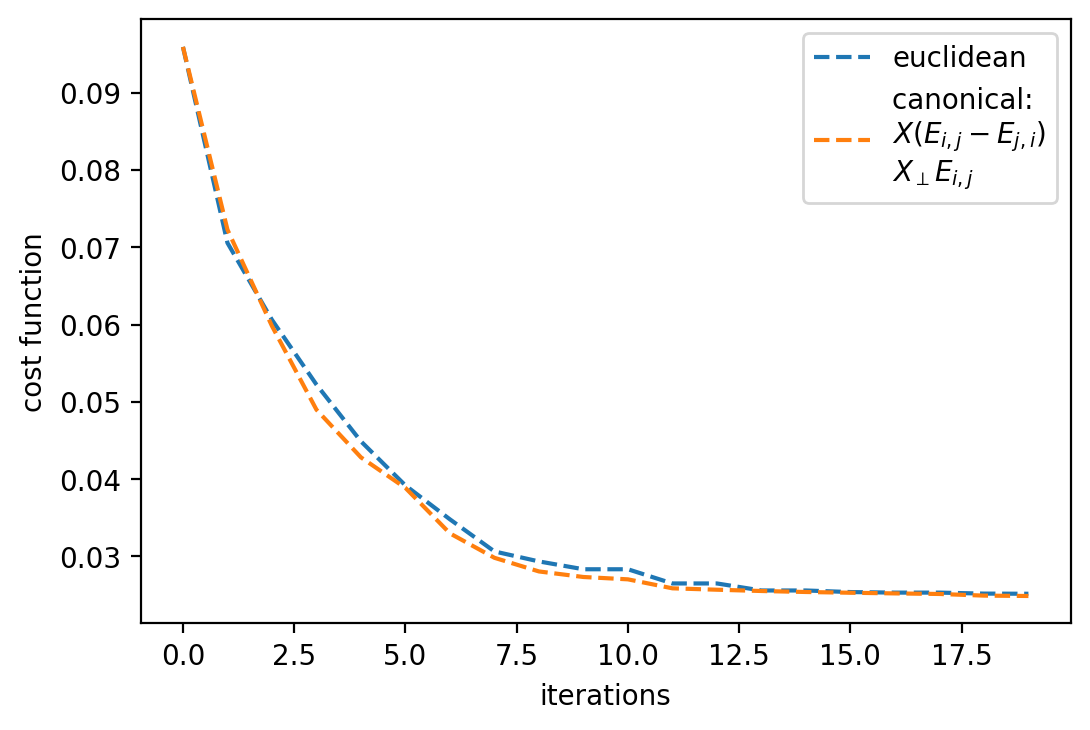

In [25]:
import matplotlib.pyplot as plt
plt.figure(dpi=200)
plt.ylabel('cost function')
plt.xlabel('iterations')
plt.plot(f_nopbc_1 + f_nopbc_2, '--', label='euclidean')
plt.plot(f_nopbc_1_canonical + f_nopbc_2_canonical, '--', label='canonical: \n' + r'$X(E_{i,j} - E_{j,i})$' + '\n' + r'$X_\perp E_{i,j} $')
plt.legend()

In [14]:
f_nopbc_1_canonical + f_nopbc_2_canonical

[DeviceArray(0.09591767, dtype=float64),
 DeviceArray(0.0722782, dtype=float64),
 DeviceArray(0.05980834, dtype=float64),
 DeviceArray(0.04898219, dtype=float64),
 DeviceArray(0.04281429, dtype=float64),
 DeviceArray(0.03885839, dtype=float64),
 DeviceArray(0.03297923, dtype=float64),
 DeviceArray(0.02982023, dtype=float64),
 DeviceArray(0.02805515, dtype=float64),
 DeviceArray(0.0273365, dtype=float64),
 DeviceArray(0.02703318, dtype=float64),
 DeviceArray(0.02587044, dtype=float64),
 DeviceArray(0.02569075, dtype=float64),
 DeviceArray(0.02552455, dtype=float64),
 DeviceArray(0.02539647, dtype=float64),
 DeviceArray(0.02530014, dtype=float64),
 DeviceArray(0.02521368, dtype=float64),
 DeviceArray(0.02514043, dtype=float64),
 DeviceArray(0.02492789, dtype=float64),
 DeviceArray(0.0248796, dtype=float64)]

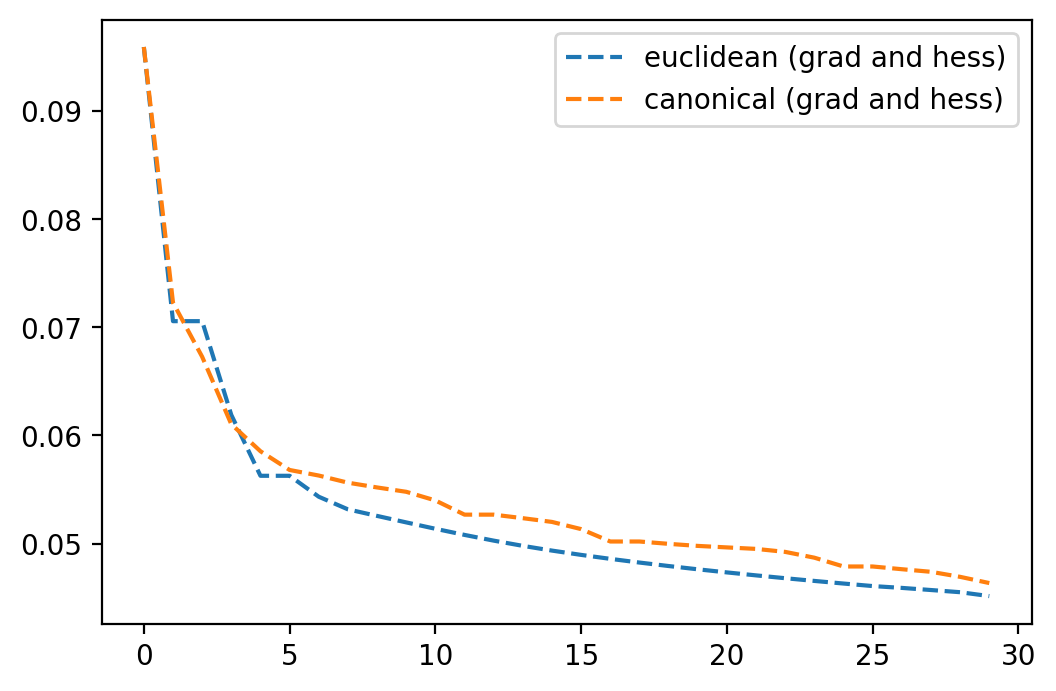

In [26]:
import matplotlib.pyplot as plt
plt.figure(dpi=200)
plt.plot(f_nopbc_1 + f_nopbc_2 + f_nopbc_3, '--', label='euclidean (grad and hess)')
plt.plot(f_nopbc_1_canonical + f_nopbc_2_canonical + f_nopbc_3_canonical, '--', label='canonical (grad and hess)')
plt.legend()